In [1]:
import os
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd

import pyrosm
import r5py
import gtfs_kit as gk

from common_functions import setup_folders, generate_point_grid, download_transitland_feeds_for_area, download_topography, plot_interpolated_grid, scatter_plot

parent_folder = "vancouver_travel_times"
setup_folders(parent_folder, ['osm', 'gtfs', 'topography'])

travel_date = "2026-01-03"

In [20]:
r5py.util.Config.CACHE_DIR = parent_folder + "/r5rpy_cache"

In [2]:
# Source - https://stackoverflow.com/a
# Posted by Taytay
# Retrieved 2025-12-28, License - CC BY-SA 4.0

from IPython.core.getipython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

ipython: InteractiveShell|None  = get_ipython()
if ipython is not None:
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")


In [3]:
#download osm data using pyrosm and save to vancouver-travel-times/osm/

osm = pyrosm.get_data("Vancouver", directory=f"{parent_folder}/osm/")

Downloaded Protobuf data 'Vancouver.osm.pbf' (56.57 MB) to:
'c:\Users\marki\Github\osm-sketches\vancouver_travel_times\osm\Vancouver.osm.pbf'


In [ ]:
# Initialize the OSM object 
osm = pyrosm.OSM(parent_folder + "/osm/Vancouver.osm.pbf")

drive_net = osm.get_network(network_type="driving")
drive_net.plot()

OSM data bounding box: [-123.2922821    48.98423386 -122.52349854   49.43198395]
Centroid: [-123.115854360464, 49.290266310518405]
Estimated UTM CRS: EPSG:32610
Number of points in x direction: 28
Number of points in y direction: 21
Generated 588 grid points.
Centroid: [np.float64(-123.10183580989366), np.float64(49.28076568874582)]
Estimated UTM CRS: EPSG:32610
                         geometry
0  POINT (479579.533 5449247.537)
1    POINT (505562.698 5468129.1)
Aspect ratio (height/width): 0.7266845004358146


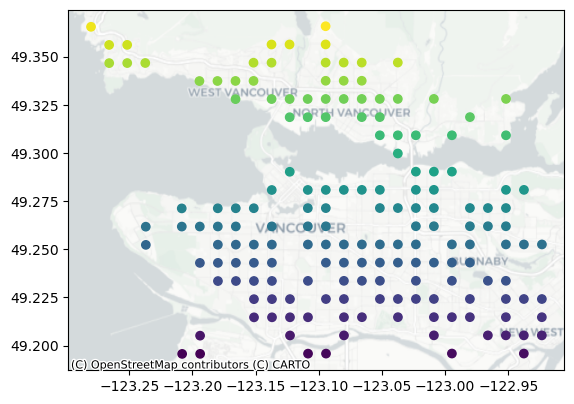

In [5]:
#get the bounding box of the osm data
bbox = drive_net.total_bounds  # minx, miny, maxx, maxy
print("OSM data bounding box:", bbox)

#p1, p2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])

p1, p2 = (49.38236143289604, -123.30470965942477)[::-1], (49.19817118814077, -122.92699906150324)[::-1]

grid_points = generate_point_grid(p1, p2, spacing=1000)

land = osm.get_landuse(
    custom_filter={
        "landuse": ["residential", "commercial", "industrial", "retail",
                    "forest", "grass", "meadow", "park", "recreation_ground"]
    }
)

land["geometry"] = land.geometry.make_valid()
land = land.dissolve()

land = land[land["landuse"].notna()]
land = land.dissolve()

grid_points = gpd.clip(grid_points, land)

scatter_plot(grid_points.geometry.x, grid_points.geometry.y, grid_points.id)

In [6]:
download_transitland_feeds_for_area(p1, p2, travel_date, parent_folder)
gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")
              ]
#Some trips have arrival or departure times > 72:00:00 hours which r5py cannot handle. Find these trips and remove them from the feed, re-saving the feed to a .zip file

for path in gtfs_paths:
    feed = gk.read_feed(path, dist_units="km")

    #check if any stop_times have arrival or departure times higher than 72:00:00 hours
    max_seconds = 72 * 3600
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time).dt.total_seconds()
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time).dt.total_seconds()

    offending_trips = feed.stop_times[(feed.stop_times.departure_time > max_seconds) | (feed.stop_times.arrival_time > max_seconds)].trip_id.unique()

    if len(offending_trips) == 0:
        print("{} trips in feed {} have arrival/departure times > 72 hours. No pruning needed.".format(len(offending_trips), path))
        continue

    print("{} trips in feed {} have arrival/departure times > 72 hours. Pruning trips.".format(len(offending_trips), path))
    #delete offending trips from feed
    feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(offending_trips)]

    #convert back to hh:mm:ss format. Format as string
    feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
    #save modified feed back to zip file
    feed.to_file(path)
    

7 unique feeds found in area.
Checking archive for f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle
Download feed for agency f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle. Date range: 2025-12-28 00:00:00 to 2026-12-28 00:00:00
Checking archive for f-9-flixbus
Download feed for agency f-9-flixbus. Date range: 2025-12-28 00:00:00 to 2026-06-27 00:00:00
Checking archive for f-c28-nstranslinkca
Download feed for agency f-c28-nstranslinkca. Date range: 2025-09-01 00:00:00 to 2026-04-19 00:00:00
Checking archive for f-c0-bcferries~bc~ca
Download feed for agency f-c0-bcferries~bc~ca. Date range: 2000-01-01 00:00:00 to 2050-01-01 00:00:00
Checking archive for f-f-viarail~traindecharlevoix
Download feed for agency f-f-viarail~traindecharlevoix. Date range: 2024-01-01 00:00:00 to 2030-12-31 00:00:00
Checking archive for f-aquabus~bc~ca
Download feed for agency f-aquabus~bc~ca. Date range: 2024-10-28 00:00:00 to 2033-12-31 00:00:00
Checking archive for f-rider~express~ca
No feed versions f

In [7]:
download_topography(p1, p2, parent_folder)

# Open the elevation raster (e.g., SRTMGL1) with rasterio.
# rasterio reads the raster along with its CRS (coordinate reference system)
# and ensures it can be interpreted correctly in Python. 
# This helps r5py apply elevation costs without running into projection errors
# (like missing Bursa-Wolf parameters or unknown EPSG codes) because
# rasterio standardizes the CRS and allows transformations if needed.

import rasterio
from rasterio.crs import CRS

src = parent_folder + "/topography/topography.tif"
dst = parent_folder + "/topography/topography-wgs.tif"

with rasterio.open(src) as ds:
    profile = ds.profile.copy()
    profile["crs"] = CRS.from_epsg(4326)  # Set to WGS84

    with rasterio.open(dst, "w", **profile) as out:
        out.write(ds.read())


Topography data downloaded successfully.


In [21]:
gtfs_paths = [parent_folder + "/gtfs/" + name for name in os.listdir(parent_folder + "/gtfs/") if name.endswith(".zip")
              ]

print(gtfs_paths[3])

transport_network = r5py.TransportNetwork(
    osm_pbf = parent_folder + "/osm/Vancouver2.osm.pbf",
    gtfs = gtfs_paths[4],
    elevation_model = parent_folder + "/topography/topography-wgs.tif"

)

vancouver_travel_times/gtfs/f-c0-bcferries~bc~ca.zip


java.io.IOError: java.io.IOError: java.io.IOException: Wrong index checksum, store was not closed properly and could be corrupted.

In [ ]:
import datetime
import geopandas as gpd
import shapely

origins = grid_points.copy()
origins.geometry = origins.geometry.centroid

destinations = gpd.GeoDataFrame(
    {
        "id": ["waterfront"],
        "geometry": [shapely.Point(-123.11962475802599, 49.28547524141578)]
    },
    crs="EPSG:4326",
)

transit_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date + " 08:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
        r5py.TransportMode.WALK
    ],
    snap_to_network=True,
)

"""bike_travel_times = r5py.TravelTimeMatrix(
    transport_network,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date, "%Y-%m-%d"),
    transport_modes=[
        r5py.TransportMode.BICYCLE,
    ],
    snap_to_network=False,
)"""

C:\Users\marki\AppData\Local\Temp\ipykernel_47864\674711942.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.geometry = origins.geometry.centroid


'bike_travel_times = r5py.TravelTimeMatrix(\n    transport_network,\n    origins=origins,\n    destinations=destinations,\n    departure=datetime.datetime.strptime(travel_date, "%Y-%m-%d"),\n    transport_modes=[\n        r5py.TransportMode.BICYCLE,\n    ],\n    snap_to_network=False,\n)'

In [ ]:
travel_times = origins.copy()

travel_times['transit'] = transit_travel_times.travel_time
#travel_times['bike'] = bike_travel_times.travel_time

travel_times = travel_times.dropna()

print(len(travel_times))
#scatter_plot(travel_times.geometry.x, travel_times.geometry.y, travel_times['transit'])

6
